In [4]:
import pandas as pd
import numpy as np
import keras 
import matplotlib.pyplot as plt
import string
import nltk
from nltk.probability import FreqDist
from nltk import word_tokenize
import gdown
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, model_selection
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import random
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
gdown.download('https://drive.google.com/uc?id=163BlB6eSlnFMuh3j3xkGgw0SbuGiyCwf', 'spam.csv', quiet=True)
df = pd.read_csv('spam.csv', encoding='latin-1', names=["Spam", "SMS", "n1", "n2", "n3"])
df = df.drop(axis=1, columns=['n1', 'n2', 'n3'])
df = df.drop(axis=0, index=[0])
print(df.head(n=10))
print(f"\n Размеры датасета: {df.shape}")

    Spam                                                SMS
1    ham  Go until jurong point, crazy.. Available only ...
2    ham                      Ok lar... Joking wif u oni...
3   spam  Free entry in 2 a wkly comp to win FA Cup fina...
4    ham  U dun say so early hor... U c already then say...
5    ham  Nah I don't think he goes to usf, he lives aro...
6   spam  FreeMsg Hey there darling it's been 3 week's n...
7    ham  Even my brother is not like to speak with me. ...
8    ham  As per your request 'Melle Melle (Oru Minnamin...
9   spam  WINNER!! As a valued network customer you have...
10  spam  Had your mobile 11 months or more? U R entitle...

 Размеры датасета: (5572, 2)


Мы используем датасет с SMS ками. Провизуализируем характеристики датасета

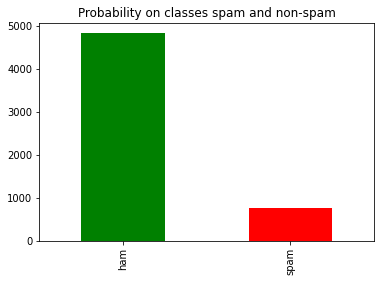

In [6]:
count_Class=pd.value_counts(df["Spam"], sort= True)
count_Class.plot(kind = 'bar',color = ["green","red"])
plt.title('Probability on classes spam and non-spam')
plt.show();

Подготовим датасет к классификации. Сначала переведем все слова в нижний регистр и удалим пунктуацию:

In [7]:
df = df.applymap(lambda s: str(s).lower())
df = df.applymap(lambda s: s.translate(str.maketrans('', '', string.punctuation)))
df.iloc[0]['SMS']

'go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat'

Также приведем метки цифрам ham->0 spam->1.

In [8]:
df["Spam"] = df["Spam"].map(lambda s: {"ham": 0, "spam": 1}[s])
df.head(n=10)

,Spam,SMS
1,0,go until jurong point crazy available only in ...
2,0,ok lar joking wif u oni
3,1,free entry in 2 a wkly comp to win fa cup fina...
4,0,u dun say so early hor u c already then say
5,0,nah i dont think he goes to usf he lives aroun...
6,1,freemsg hey there darling its been 3 weeks now...
7,0,even my brother is not like to speak with me t...
8,0,as per your request melle melle oru minnaminun...
9,1,winner as a valued network customer you have b...
10,1,had your mobile 11 months or more u r entitled...


Теперь провизуализируем распределения слов по классам

Всего слов в датасете: 9558
Список слов, которые выделяются больше в не-спам сообщениях (неспам\спам) 
: [['u', 972], ['and', 848], ['in', 811], ['me', 767], ['my', 743], ['is', 728], ['it', 590], ['of', 524], ['for', 501], ['that', 486], ['im', 449], ['have', 438], ['but', 418], ['your', 414], ['so', 412], ['not', 411], ['are', 409], ['on', 391], ['can', 381], ['at', 377], ['do', 377], ['if', 347], ['will', 334], ['be', 332], ['2', 305], ['get', 303], ['we', 297], ['its', 297], ['now', 289], ['just', 289], ['up', 282], ['ltgt', 276], ['when', 273], ['no', 272], ['ok', 272], ['with', 271], ['dont', 257], ['how', 255], ['go', 247], ['this', 243], ['got', 243], ['what', 242], ['ur', 240], ['all', 239], ['ill', 236], ['know', 232], ['like', 229], ['or', 228], ['come', 224], ['then', 223], ['good', 222], ['was', 222], ['out', 211], ['am', 210], ['time', 189], ['day', 187], ['there', 185], ['love', 185], ['he', 184], ['4', 168], ['going', 167], ['want', 163], ['one', 162], ['home', 160], ['

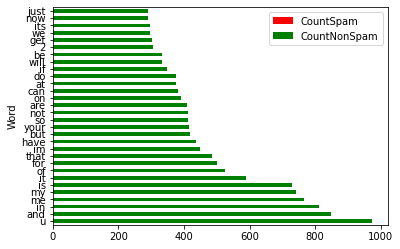

In [9]:
def get_probability_info():
  tokens_nonspam = []
  tokens_spam = []
  df[df["Spam"]==0]["SMS"].map(lambda s: tokens_nonspam.extend(word_tokenize(s)))
  df[df["Spam"]==1]["SMS"].map(lambda s: tokens_spam.extend(word_tokenize(s)))

  text = nltk.Text(tokens_nonspam)
  fdist = dict(FreqDist(text))
  fdist_nonspam = { item: fdist[item] for item in fdist if fdist[item]<1000}

  text = nltk.Text(tokens_spam)
  fdist = dict(FreqDist(text))
  fdist_spam = { item: fdist[item] for item in fdist if fdist[item]<1000}

  words = set(tokens_spam+tokens_nonspam)
  print(f"Всего слов в датасете: {len(words)}")
  words_dist = {}
  for word in words:
    nspam_prob = fdist_nonspam[word] if word in fdist_nonspam else 0
    spam_prob = fdist_spam[word] if word in fdist_spam else 0
    words_dist[word] = (nspam_prob, spam_prob)

  sorted_words_dict = dict(sorted(list(words_dist.items()), key=lambda x: x[1][0]*1000+x[1][1], reverse=True))

  more_to_n_spam_words = [ [word, sorted_words_dict[word][0]] for word in sorted_words_dict if (sorted_words_dict[word][0] > sorted_words_dict[word][1])]
  more_to_spam_words = [ [word, sorted_words_dict[word][1]] for word in sorted_words_dict if (sorted_words_dict[word][0] < sorted_words_dict[word][1])]
  words = [ [word, sorted_words_dict[word][1], sorted_words_dict[word][0]] for word in sorted_words_dict]
  print(f"Список слов, которые выделяются больше в не-спам сообщениях (неспам\спам) \n: {more_to_n_spam_words}")
  print(f"Список слов, которые выделяются больше в спам сообщениях (неспам\спам) \n: {more_to_spam_words}")
  pd.DataFrame(words[:30], columns=["Word", "CountSpam", "CountNonSpam"])
  spam_plot.plot.barh(x = "Word", y = "CountSpam", color="red")
  spam_plot.plot.barh(x = "Word", y = "CountNonSpam", color="green")
  
get_probability_info()

Также проанализируем тексты смс на распределение длины чтобы определить параметры ембеддинга


The longest SMS has length: 171


<BarContainer object of 67 artists>

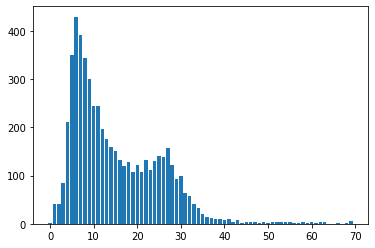

In [10]:
num_words = df["SMS"].apply(lambda x: len(nltk.word_tokenize(x)))
print(f"The longest SMS has length: {num_words.max()}")
lens = [i for i in range(0, num_words.max()) if i in num_words.value_counts() and i < 70]
probs = [(num_words.value_counts()[i]) for i in lens]
plt.bar(lens, probs)

Оставим значение длины маскимального предложения от 50 до 70 слов.

Мы видим различные номера в распределении. Переведем номера в кодовое слово - XXXNUMBERXXX,  потом можно будет выделить как дополнительныю фичу.

In [12]:
#обработчики
def remove_numbers(w):
  if w.isnumeric() or sum([w.count(str(i)) for i in range(0,10)]) > 3:
    return "XXXNUMBERXXX"
  else:
    return remove_punct(w)

def remove_punct(word):
  result = word.translate(str.maketrans('', '', string.punctuation))
  return result

def transform(text):
  result = []
  for w in text.split(' '): 
    result.append(remove_numbers(w))
  return ' '.join(result)

df["SMS"] = df["SMS"].map(lambda s: transform(s))
df.head(n=10)

,Spam,SMS
1,0,go until jurong point crazy available only in ...
2,0,ok lar joking wif u oni
3,1,free entry in XXXNUMBERXXX a wkly comp to win ...
4,0,u dun say so early hor u c already then say
5,0,nah i dont think he goes to usf he lives aroun...
6,1,freemsg hey there darling its been XXXNUMBERXX...
7,0,even my brother is not like to speak with me t...
8,0,as per your request melle melle oru minnaminun...
9,1,winner as a valued network customer you have b...
10,1,had your mobile XXXNUMBERXXX months or more u ...


Посмотрим теперь на распределение, и если все ок, начнем обучать. Будем использовать сверточную нейросеть.

Уже конкретнее представление.  Используем свертку одномерную.
Сначала применим токенизацию и переведем слова в числа, а числовые последовательности приведем к единой длине 30 слов. Используя получившиеся данные будем обучать модель: 

In [13]:
 # Global parameters
 num_words = 9558
 max_message_len = 30
 vector_size = 30

In [36]:
print("Применяем перевод текста в числовую последовательность")
x_train, x_test, y_train, y_test = model_selection.train_test_split(df["SMS"], df['Spam'], test_size=0.2, random_state=78)
tokenizer = Tokenizer(num_words= num_words)
tokenizer.fit_on_texts([*x_train, *x_test])
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_train = pad_sequences(x_train, maxlen=max_message_len)
x_test = pad_sequences(x_test, maxlen=max_message_len)
print(f" Разделили датасет на тренировочную часть: {np.shape(x_train)[0]} сэмплов и тестовую {np.shape(x_test)[0]} в каждом по {np.shape(x_test)[1]} слов")

Применяем перевод текста в числовую последовательность
 Разделили датасет на тренировочную часть: 4457 сэмплов и тестовую 1115 в каждом по 30 слов


Будем использовать сверточную нейросеть с размером окна 3 и скрытым слоем. Выходом будет значение в промежутке [0;1]  

In [72]:
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=vector_size, input_length=max_message_len))
model.add(Conv1D(100, 3, activation="relu"))
model.add(MaxPooling1D())
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


In [12]:
history = model.fit(x_train, y_train, batch_size=10, epochs=20, validation_split=0.1)

Epoch 1/20
402/402 [==============================] - 17s 8ms/step - loss: 0.2620 - accuracy: 0.9167 - val_loss: 0.2173 - val_accuracy: 0.9345
Epoch 2/20
402/402 [==============================] - 3s 7ms/step - loss: 0.1634 - accuracy: 0.9530 - val_loss: 0.2106 - val_accuracy: 0.9387
Epoch 3/20
402/402 [==============================] - 3s 7ms/step - loss: 0.1401 - accuracy: 0.9611 - val_loss: 0.2099 - val_accuracy: 0.9383
Epoch 4/20
402/402 [==============================] - 3s 7ms/step - loss: 0.1302 - accuracy: 0.9643 - val_loss: 0.2125 - val_accuracy: 0.9395
Epoch 5/20
402/402 [==============================] - 3s 7ms/step - loss: 0.1235 - accuracy: 0.9661 - val_loss: 0.2183 - val_accuracy: 0.9393
Epoch 6/20
402/402 [==============================] - 3s 7ms/step - loss: 0.1176 - accuracy: 0.9683 - val_loss: 0.2233 - val_accuracy: 0.9391
Epoch 7/20
402/402 [==============================] - 3s 7ms/step - loss: 0.1137 - accuracy: 0.9699 - val_loss: 0.2263 - val_accuracy: 0.9382
Epoch

In [17]:
def plot_loss(history, epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(25,10))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Точность на обучении')
  plt.plot(epochs_range, val_acc, label='Точность на валидации')
  plt.legend(loc='lower right')
  plt.title('Точность на обучающих и валидационных данных')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Потери на обучении')
  plt.plot(epochs_range, val_loss, label='Потери на валидации')
  plt.legend(loc='upper right')
  plt.title('Потери на обучающих и валидационных данных')
  plt.show()

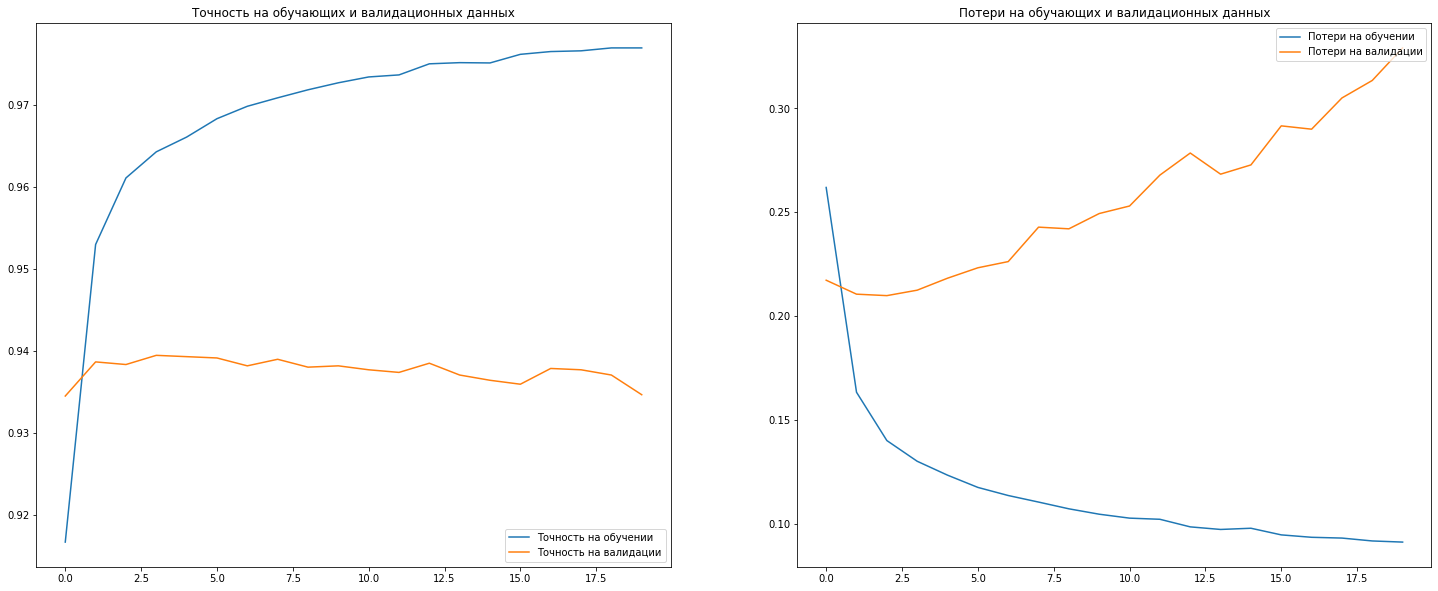

Точность модели по метрике Accuracy: 93.93%
35/35 [==============================] - 0s 4ms/step - loss: 0.2887 - accuracy: 0.9393
Точность по метрике accuracy : 93.93% Значение функции ошибки 0.2886849045753479


In [13]:
plot_loss(history, 20)
scores = model.evaluate(x_test, y_test, verbose=0)
print("Точность модели по метрике Accuracy: %.2f%%" % (scores[1]*100))
classes = model.predict(x_test, batch_size=128)
info = model.evaluate(x_test, y_test)
print(f"Точность по метрике accuracy : {int(info[1]*10000)/100}% Значение функции ошибки {info[0]}")

Получили метрику 93% Заметно переобучение по большому расстоянию между графиками. Попробуем применить Dropout

In [73]:
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=vector_size, input_length=max_message_len))
model.add(Conv1D(100, 3, activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPooling1D())
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

Epoch 1/10
402/402 [==============================] - 4s 9ms/step - loss: 0.2654 - accuracy: 0.9123 - val_loss: 0.2325 - val_accuracy: 0.9324
Epoch 2/10
402/402 [==============================] - 3s 8ms/step - loss: 0.1693 - accuracy: 0.9522 - val_loss: 0.2096 - val_accuracy: 0.9390
Epoch 3/10
402/402 [==============================] - 3s 8ms/step - loss: 0.1477 - accuracy: 0.9597 - val_loss: 0.2114 - val_accuracy: 0.9374
Epoch 4/10
402/402 [==============================] - 3s 8ms/step - loss: 0.1379 - accuracy: 0.9632 - val_loss: 0.2083 - val_accuracy: 0.9399
Epoch 5/10
402/402 [==============================] - 3s 8ms/step - loss: 0.1301 - accuracy: 0.9651 - val_loss: 0.2170 - val_accuracy: 0.9399
Epoch 6/10
402/402 [==============================] - 3s 8ms/step - loss: 0.1284 - accuracy: 0.9659 - val_loss: 0.2230 - val_accuracy: 0.9382
Epoch 7/10
402/402 [==============================] - 3s 8ms/step - loss: 0.1216 - accuracy: 0.9680 - val_loss: 0.2319 - val_accuracy: 0.9385
Epoch 

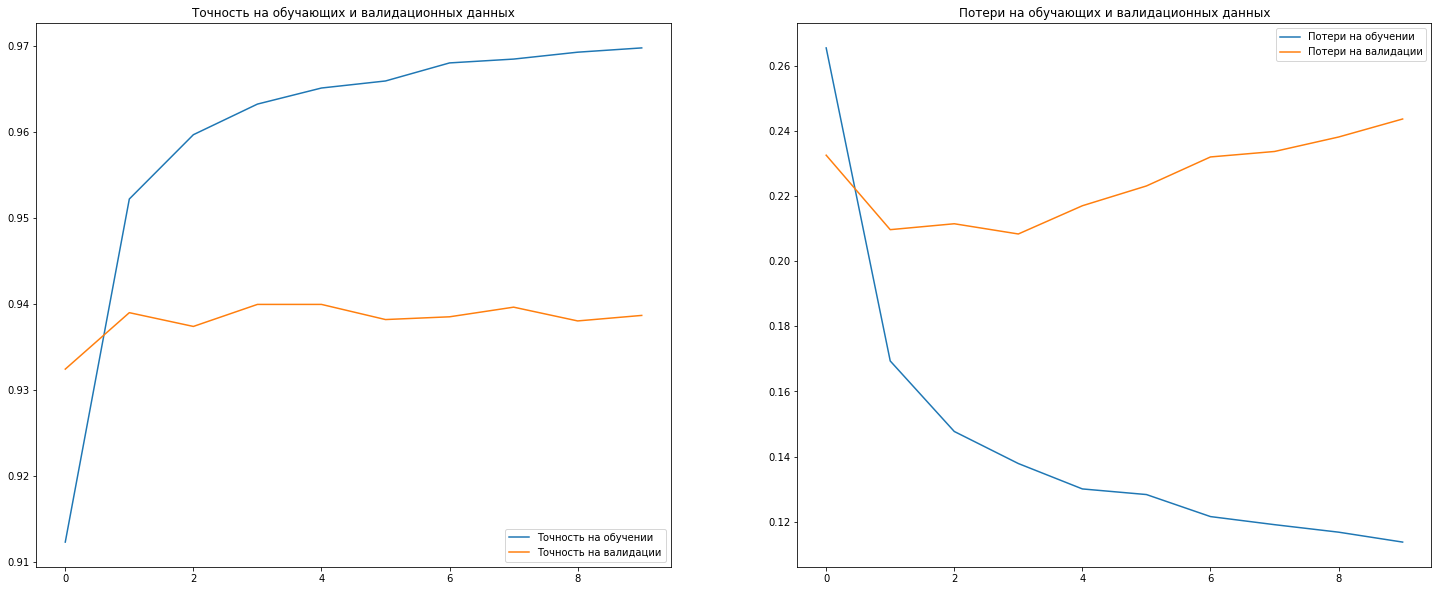

Точность модели по метрике Accuracy: 94.04%
35/35 [==============================] - 0s 3ms/step - loss: 0.2228 - accuracy: 0.9404
Точность по метрике accuracy : 94.03% Значение функции ошибки 0.22275912761688232


In [74]:
history = model.fit(x_train, y_train, batch_size=10, epochs=10, validation_split=0.1)
plot_loss(history, 10)
scores = model.evaluate(x_test, y_test, verbose=0)
print("Точность модели по метрике Accuracy: %.2f%%" % (scores[1]*100))
classes = model.predict(x_test, batch_size=128)
info = model.evaluate(x_test, y_test)
print(f"Точность по метрике accuracy : {int(info[1]*10000)/100}% Значение функции ошибки {info[0]}")

получили точность по метрике accuracy - 94%

Также попробуем использовать модель LSTM - Long short-term memory . Длину цепи возьмем 10, опираясь на график распределение длины и добавим дропаут нейронов для защиты от переобучения

In [97]:
model = Sequential()
model.add(Embedding(9558, output_dim=32, input_length=30))
model.add(LSTM(100))
model.add(Dense(20, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 30, 32)            305856    
                                                                 
 lstm_3 (LSTM)               (None, 100)               53200     
                                                                 
 dense_10 (Dense)            (None, 20)                2020      
                                                                 
 dense_11 (Dense)            (None, 1)                 21        
                                                                 
Total params: 361,097
Trainable params: 361,097
Non-trainable params: 0
_________________________________________________________________


In [98]:
history = model.fit(x_train, y_train, batch_size=32, epochs=5, validation_split=0.1)
scores = model.evaluate(x_test, y_test, verbose=0)
print("Точность модели по метрике Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/5
126/126 [==============================] - 7s 36ms/step - loss: 0.2177 - accuracy: 0.9297 - val_loss: 0.0646 - val_accuracy: 0.9821
Epoch 2/5
126/126 [==============================] - 4s 32ms/step - loss: 0.0380 - accuracy: 0.9890 - val_loss: 0.0494 - val_accuracy: 0.9865
Epoch 3/5
126/126 [==============================] - 4s 32ms/step - loss: 0.0174 - accuracy: 0.9953 - val_loss: 0.0511 - val_accuracy: 0.9888
Epoch 4/5
126/126 [==============================] - 4s 32ms/step - loss: 0.0078 - accuracy: 0.9983 - val_loss: 0.0528 - val_accuracy: 0.9865
Epoch 5/5
126/126 [==============================] - 4s 32ms/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.0612 - val_accuracy: 0.9865
Точность модели по метрике Accuracy: 98.03%


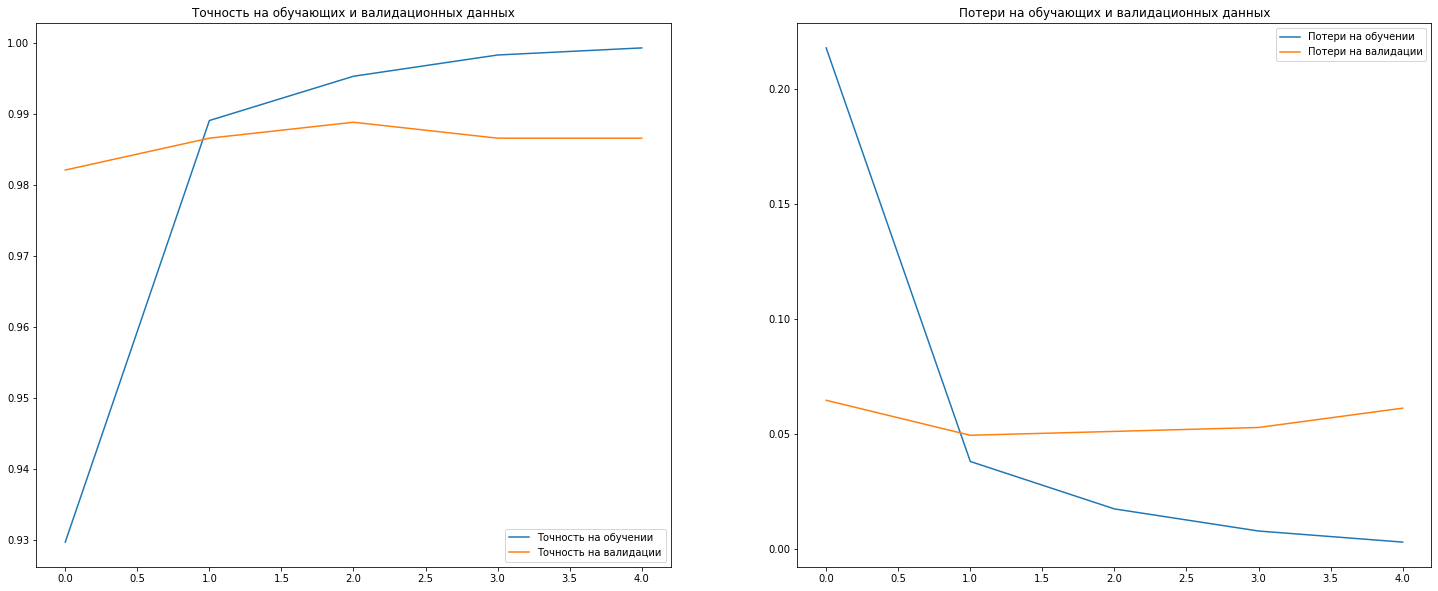

Точность модели по метрике Accuracy: 98.03%
35/35 [==============================] - 0s 8ms/step - loss: 0.0656 - accuracy: 0.9803
Точность по метрике accuracy : 98.02% Значение функции ошибки 0.06562932580709457
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       956
           1       0.93      0.95      0.94       159

    accuracy                           0.98      1115
   macro avg       0.96      0.97      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [99]:
plot_loss(history, 5)

scores = model.evaluate(x_test, y_test, verbose=0)
print("Точность модели по метрике Accuracy: %.2f%%" % (scores[1]*100))
classes = model.predict(x_test)
for i in range(len(classes)):
  classes[i] = int(classes[i] > 0.6)
info = model.evaluate(x_test, y_test)
print(f"Точность по метрике accuracy : {int(info[1]*10000)/100}% Значение функции ошибки {info[0]}")
print(classification_report(y_test, classes))

С помощью LSTM мы получили точность по метрике accuracy 98.74% уже после 6 эпохи. Продемонстрируем работу алгоритма:

In [108]:
def prep_sms(message):
  def remove_numbers(w):
    if w.isnumeric() or sum([w.count(str(i)) for i in range(0,10)]) > 3:
      return "XXXNUMBERXXX"
    else:
      return remove_punct(w)

  def remove_punct(word):
    result = word.translate(str.maketrans('', '', string.punctuation))
    return result

  def transform(text):
    result = []
    for w in text.split(' '): 
      result.append(remove_numbers(w))
    return ' '.join(result)
  
  message = message.split(' ')
  for item in range(len(message)):
    message[item] = transform(message[item])
  message = ' '.join(message)
  gdown.download('https://drive.google.com/uc?id=163BlB6eSlnFMuh3j3xkGgw0SbuGiyCwf', 'spam.csv', quiet=True)
  df = pd.read_csv('spam.csv', encoding='latin-1', names=["Spam", "SMS", "n1", "n2", "n3"])
  df = df.drop(axis=1, columns=['n1', 'n2', 'n3'])
  df = df.drop(axis=0, index=[0])
  x_train, x_test, y_train, y_test = model_selection.train_test_split(df["SMS"], df['Spam'], test_size=0.2, random_state=78)
  tokenizer = Tokenizer(num_words=num_words)
  tokenizer.fit_on_texts([*x_train, *x_test])
  x = tokenizer.texts_to_sequences(message)
  x = [ i[0] if len(i) > 0 else 1 for i in x ]
  x = pad_sequences([x], maxlen=max_message_len)
  return x[0]

def predict_spam(token_pads):
  return model.predict(np.array([token_pads]))


In [112]:
sms_spam = "hey call 8989883322 to have free sex. send free sms on number 234324234 and new free mobile game top ur"
sms_no_spam = "i love u! can we go cafe on evening? miss u"
print(f"Message: {sms_spam},\nexpected: 1 (Spam),\nresult probability: {int(predict_spam(prep_sms(sms_spam))[0][0]*100)}% spam \n")
print(f"Message: {sms_no_spam},\nexpected: 0 (No-Spam),\nresult probability: {int(predict_spam(prep_sms(sms_no_spam))[0][0]*100)}% spam")

Message: hey call 8989883322 to have free sex. send free sms on number 234324234 and new free mobile game top ur,
expected: 1 (Spam),
result probability: 22% spam 

Message: i love u! can we go cafe on evening? miss u,
expected: 0 (No-Spam),
result probability: 84% spam


По моим наблюдениям, при применении модели с дропаутом получаем странные значения - около 50%.  Поэтому я выкинул дропаут из модели. 